## Shortlist Promising Models - Decision Tree Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
from module.utils import model_performance_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df_file = "../data/train_df.csv"

target_attr = "label"
target_type = "binary"

estimator_name = "DecisionTreeClassifier"

sample_random_state = 24
target_encoding_random_state = 42
model_random_state = 42
permutation_importance_random_state = 0

#### 1. Import Data

In [3]:
train_df = general_utils.read_csv(train_df_file)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1641431,5177,1998,7,191,60,5,21,82,14,...,2,-1,-1,-1,2,-1,6,24,3,0
1,2021896,4628,4530,7,177,56,5,17,31,40,...,3,18,-1,-1,2,10^11^12^13^14^15^16^17^18^19^20^21^22^23,7,17,3,0
2,1790795,2709,1413,7,134,55,4,17,65,18,...,5,20,-1,-1,5,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,14,1,0
3,1216709,1949,6143,7,150,17,5,21,11,39,...,2,16,-1,-1,2,8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,36,3,0
4,1635521,4806,2176,7,206,64,5,15,22,39,...,4,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,36,1,0


df.shape: (838142, 36)


#### 2. Sample smaller training sets for fast exploration

In [4]:
train_df_sample = data_prepare_utils.sample_data(train_df, 0.01, random_state=sample_random_state)


Sample 0.01 fraction from DataFrame:
sample_df.shape: (8381, 36)


#### 3. Check attribute types

In [5]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df_sample.columns if attr not in numerical_attr_list and attr != target_attr]
attr_list = numerical_attr_list + categorical_attr_list
attr_list

['uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

#### 4. Predefined data processing strategy in prep.ipynb

In [6]:
train_df_sample = data_prepare_utils.drop_duplicate_obs(train_df_sample)


Drop duplicate observations:
df.shape:  (8381, 36)
drop_dup_df.shape:  (8380, 36)


In [7]:
attrs_to_drop = ['app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id', 'app_second_class', 'adv_prim_id', 'device_price']


preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop, target_type, target_encoding_random_state)

#### 5. Define default model

In [8]:
estimator = DecisionTreeClassifier(random_state=model_random_state)

#### 6. Define composite model

In [9]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [10]:
cap_x_df, y_df = train_df_sample.drop(columns=target_attr), train_df_sample[[target_attr]]
del train_df_sample

In [11]:
composite_estimator.fit(
    cap_x_df,
    y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id',
                                                                                                         'app_second_class',
                                                                                                         'adv_prim_id',
                                                                                                         'device_price'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical'...
                                                   'spread_app_id', 'tags',
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', DecisionTreeClassifier(random_state=42))])

#### 7. Performance using N-fold cross validation

In [12]:
model_performance_utils.check_out_cross_val_score(composite_estimator, cap_x_df, y_df)

Cross Validation Scores: [0.94212411 0.93615752 0.93317422 0.93675418 0.93735084]
mean: 0.9371121718377088
standard deviation: 0.0032296822440869956


#### 8. Check the most significant attributes

In [13]:
model_performance_utils.check_out_permutation_importance(
    composite_estimator, 
    cap_x_df, 
    y_df, 
    permutation_importance_random_state
)


Permutation importance:

metric: sqrt_neg_mean_squared_error
    slot_id  0.097 +/- 0.044
    inter_type_cd 0.088 +/- 0.032
    his_app_size 0.087 +/- 0.033
    indu_name 0.077 +/- 0.028
    list_time 0.063 +/- 0.025
    age      0.060 +/- 0.031
    residence 0.059 +/- 0.035
    city     0.058 +/- 0.024
    device_size 0.055 +/- 0.025
    app_first_class 0.051 +/- 0.020
    up_life_duration 0.049 +/- 0.024
    emui_dev 0.044 +/- 0.025
    adv_id   0.044 +/- 0.030
    creat_type_cd 0.036 +/- 0.022
    consume_purchase 0.034 +/- 0.019
    career   0.031 +/- 0.020


#### 9. Analyze error types
Based on the confusion matrix, 7956 (7906 + 50) predictions are correct and 424 (239 + 185) predictions are incorrect.

Check accuracy score
train sample set accuracy score: 0.9494033412887828

Check confusion matrix
train sample set confusion matrix: 
[[7906  185]
 [ 239   50]]
True Positives =  7906
True Negatives =  50
False Positives(Type I error) =  185
False Negatives(Type II error) =  239

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8091
           1       0.21      0.17      0.19       289

    accuracy                           0.95      8380
   macro avg       0.59      0.58      0.58      8380
weighted avg       0.94      0.95      0.95      8380


Check the ROC Curve and AUC
The area under the curve (AUC):  0.5750727344963155


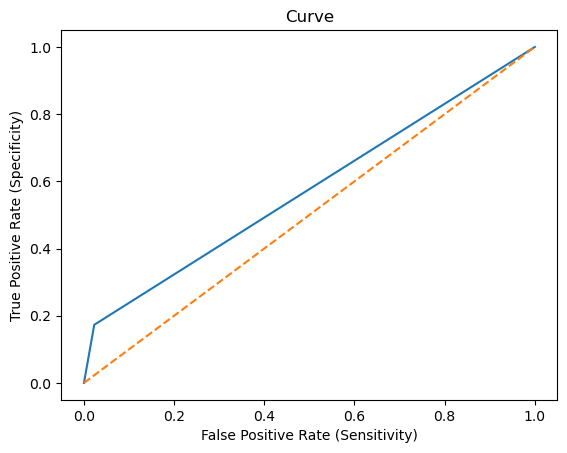

In [14]:
bin_class_utils.eval_class(cap_x_df, y_df, composite_estimator, 'train sample')

#### 10. Feature selection and engineering

In [15]:
#exp_attrs_to_drop = [] + attrs_to_drop

#### 11. Fit and evaluate again

In [16]:
#exp_preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, exp_attrs_to_drop, target_type, target_encoding_random_state)
#exp_composite_estimator = Pipeline(steps=[('preprocessor', exp_preprocessor), ('estimator', estimator)])
#exp_composite_estimator.fit(
#    cap_x_df,
#    y_df.values.ravel()
#)

In [17]:
#model_performance_utils.check_out_cross_val_score(exp_composite_estimator, cap_x_df, y_df)

In [18]:
#bin_class_utils.eval_class(cap_x_df, y_df, exp_composite_estimator, 'train sample')

#### 12. Check the most promising models

#### Other steps

In [19]:
# feature importance
new_categorical_attr_list = [attr for attr in categorical_attr_list if attr not in attrs_to_drop]
feature_importance_df = bin_class_utils.get_feature_importance_df(composite_estimator, new_categorical_attr_list, estimator_name)
feature_importance_df

,Feature,Importance
14,residence,0.088076
17,list_time,0.073258
1,adv_id,0.072740
4,slot_id,0.061376
9,device_name,0.060715
22,communication_onlinerate,0.056640
25,pt_d,0.055798
6,age,0.052094
8,city_rank,0.047862
7,city,0.047466


In [20]:
from sklearn.inspection import permutation_importance
def compute_permutation_importance_logreg(model, cap_x_df, y_df, random_state=42, n_repeats=10):

    original_score = model.score(cap_x_df, y_df)

    perm_importance = permutation_importance(model, cap_x_df, y_df, n_repeats=n_repeats, random_state=random_state)
    perm_importance_scores = perm_importance.importances_mean
    perm_importance_df = pd.DataFrame({'Feature': cap_x_df.columns, 'Permutation_Importance': perm_importance_scores})
    perm_importance_df = perm_importance_df.sort_values(by='Permutation_Importance', ascending=False).reset_index(drop=True)

    return perm_importance_df

In [21]:
result_df = compute_permutation_importance_logreg(composite_estimator, cap_x_df, y_df, random_state=42, n_repeats=10)

In [22]:
combined_df = pd.merge(result_df, feature_importance_df, how='outer', on='Feature')

In [23]:
t_attrs_to_drop = combined_df[combined_df['Permutation_Importance'] <= 0]['Feature']
t_attrs_to_drop

23                   app_score
24           his_on_shelf_time
25                device_price
26                     task_id
27            app_second_class
28    membership_life_duration
29                        tags
30               spread_app_id
31                      dev_id
32                 adv_prim_id
33                      gender
34                        pt_d
Name: Feature, dtype: object

In [24]:
attrs_to_drop

['app_score',
 'his_on_shelf_time',
 'task_id',
 'spread_app_id',
 'tags',
 'dev_id',
 'app_second_class',
 'adv_prim_id',
 'device_price']

In [25]:
exp_preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, t_attrs_to_drop, target_type, target_encoding_random_state)
exp_composite_estimator = Pipeline(steps=[('preprocessor', exp_preprocessor), ('estimator', estimator)])
exp_composite_estimator.fit(
    cap_x_df,
    y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=23                   app_score
24           his_on_shelf_time
25                device_price
26                     task_id
27            app_second_class
28    membership_life_duration
29                        tags
30               spread_app_id
31                      dev_id
32                 adv_prim_id
33                      gender
34                        pt_d
Name: Feature, dtype: object)),
                                                                  ('imputer',
                                                                   SimpleImpu...
                                                   'spread_app_id', 'tags',
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', DecisionTreeClassifier(random_state=42))])

In [26]:
model_performance_utils.check_out_cross_val_score(exp_composite_estimator, cap_x_df, y_df)

Cross Validation Scores: [0.94152745 0.93735084 0.93615752 0.92183771 0.94570406]
mean: 0.9365155131264917
standard deviation: 0.009025141002954169


Check accuracy score
train sample set accuracy score: 0.9465393794749404

Check confusion matrix
train sample set confusion matrix: 
[[7883  208]
 [ 240   49]]
True Positives =  7883
True Negatives =  49
False Positives(Type I error) =  208
False Negatives(Type II error) =  240

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8091
           1       0.19      0.17      0.18       289

    accuracy                           0.95      8380
   macro avg       0.58      0.57      0.58      8380
weighted avg       0.94      0.95      0.95      8380


Check the ROC Curve and AUC
The area under the curve (AUC):  0.5719212983455068


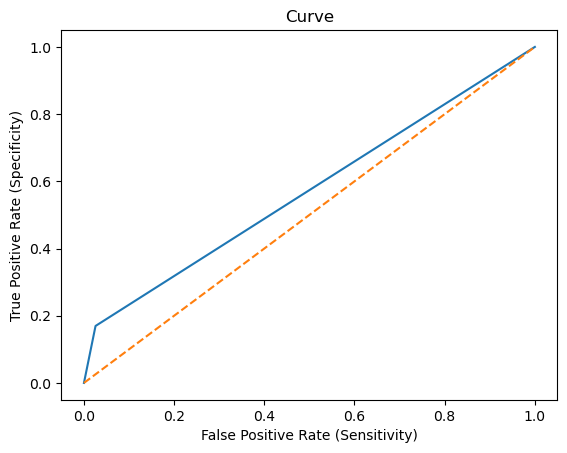

In [27]:
bin_class_utils.eval_class(cap_x_df, y_df, exp_composite_estimator, 'train sample')